# Load in packages

#### code Source: 
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://nlpforhackers.io/topic-modeling/
- https://primer.ai/blog/Chinese-Word-Vectors/
- https://github.com/crownpku/awesome-chinese-nlp#toolkits-%E7%BB%BC%E5%90%88nlp%E5%B7%A5%E5%85%B7%E5%8C%85-1

In [2]:
from __future__ import absolute_import, division, print_function
# for word vec
import gensim
from gensim.models import Word2Vec as w2v
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer

import codecs
import glob
import multiprocessing
import os
import nltk
import pprint
import re
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import jieba
import itertools

# What is a Word Vector

##  It is a row of real valued numbers (as opposed to dummy numbers) where each point captures a dimension of the word’s meaning and where semantically similar words have similar vectors. This means that words such as wheel and engine should have similar word vectors to the word car (because of the similarity of their meanings), whereas the word banana should be quite distant.
> * source: https://medium.com/@jayeshbahire/introduction-to-word-vectors-ea1d4e4b84bf

In [5]:
print(os.listdir("../ASUS/desktop/Thesis/codes"))
#MIIT = pd.read_csv("../Thesis/BIG_MIIT_UNIQUE.csv")
df = pd.DataFrame(pd.read_csv('../ASUS/desktop/Thesis/codes/BIG_MIIT_UNIQUE.csv',encoding='GBK')) 
df.title.tail()

['.Rhistory', 'BIG_MIIT_UNIQUE.csv', 'CIPI_text.Rmd', 'polytech.R', 'polytech_werk.RData', 'polytech_wordEmbed.RData', 'scrape_ver0.R']


9198    关于政协十三届全国委员会第一次会议第2241号（工交邮电类163号）提案答复的函（摘要）
9199       公开征集对《腐植酸肥料增效剂》等377项行业标准和52项国家标准计划项目的意...
9200              公开征集对《搪玻璃设备技术条件》等22项强制性国家标准计划项目的意见
9201       申报工业和信息化部《道路机动车辆生产企业及产品公告》（第311批）的车辆新产...
9202       《道路机动车辆生产企业及产品公告》（第311批）拟发布的新增车辆生产企业及已...
Name: title, dtype: object

# GOAL : create word vec from ministry  websites  and analyse them to see semantic similarities


> ### Step 1: Functions we need to perform 

In [126]:
import jieba
import string
import nltk
from pandas import DataFrame

def get_chinese_characters(raw):
    """Return list of Chinese characters in sentence.
    :param raw: raw chinese text
    """
    return list(sentence)

def get_chinese_words(raw):
    """Return list of Chinese words in sentence without stopwords. 
    :param raw: raw chinese text
    """
    stop_words = open("C:/Users/ASUS/Desktop/Thesis/stop_words/stop_words.txt")
    stop_words = stop_words.read()
    tokens = jieba.lcut(raw)
    result = [i for i in tokens if not i in stop_words]
    return result
    
def get_chinese_character_positions(raw):
    """Return a list of characters with their positions in the words. 
    :param raw: raw chinese text
    """
    return [u'{}{}'.format(char, i)
            for word in get_chinese_words(raw)
            for i, char in enumerate(word)]

def get_topic_distribution(lda_model, raw_input, dictionary):
    """Return a vecor of topical distribution of each document or text. 
    :param lda_model: the output of the function gensim.models.ldamodel.LdaModel
    :param raw_imput: raw chinese policy text or doc
    :param dictionary: the output of corpora.Dictionary() function which is the vocab.
    """
    other_texts = [ # needs tokenized
        get_chinese_words(raw_input)
    ]
    #dictionary = Dictionary(sentences)
    other_corpus = [dictionary.doc2bow(text) for text in other_texts]
    unseen_doc = other_corpus[0]
    vector = lda_model[unseen_doc][0]
    return(DataFrame.from_records(vector)[1])

In [7]:
#sent = df.title.str.cat()
sent = list(df.title)
sent[0:6]

['集成电路设计企业及产品认定管理办法问答',
 '集成电路设计企业及产品认定管理办法问答',
 '苏金生局长就重新调整《电信业务分类目录》答记者问',
 '苏金生局长就重新调整《电信业务分类目录》答记者问',
 '彭晓芳副司长解读电信资费监管思路\u3000积极稳妥推进资费改革',
 '彭晓芳副司长解读电信资费监管思路\u3000积极稳妥推进资费改革']

In [8]:
sentences = []
for i in sent:
    sentences.append(get_chinese_words(i))

sentences[2] # NO SHITTY STOP WORDS!

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ASUS\AppData\Local\Temp\jieba.cache
Loading model cost 0.813 seconds.
Prefix dict has been built succesfully.


['苏金生', '局长', '重新', '调整', '电信业务', '分类目录', '答记者问']

### Classification and Bag of Words Dictionary:
> * Each post goes into each bag (Hangye, Themes, type) to output the most probable topic, industry, theme, and policy type
> * Each post will output the % of elements of each Hanye, Themes,Types_policy it represent, e.g. post A has 20% 农业，30% 房地产， 50% 信息 for Hange. Is that possible?

In [9]:
Hangye = [
    "非政府组织",
    "农业", 
    "化妆品",
    "制药和医疗卫生服务", 
    "航空航天",
    "机械设备",
    "汽车",
    "车辆",
    "专业服务",
    "化工",
    "石油",
    "制造",
    "制造业",
    "法律",
    "土木工程与建筑",
    "医疗设备",
    "食品和饮料",
    "运输，物流和配送",
    "金融服务,保险",
    "信息和通信技术",
    "能源",
    "教育",
    "媒体和娱乐业",
    "房地产",
    "零售和电子商务",
    "体育"]

Themes = [
  "竞争法规",
  "合规",
  "关税和贸易",
  "政府采购",
  "补贴",
  "补助",
  "出口管控",
  "知识产权",
  "标准",
  "认证和合格评定",
  "税收",
  "研发",
  "产业基金",
  "创新",
  "网络安全",
  "技术转让",
  "市场准入",
  "一带一路",
  "国有企业",
  "环境保护"
  "中国",
  "制造2025"]
  
types_policy = [
  "法律",
  "行政法规",
  "监察法规",
  "司法解释",
  "部门规章",
  "军事法规规章",
  "党内法规",
  "团体规定",
  "行业规定",
  "政府新闻稿",
  "演讲",
  "数据",
  "政策分析",
  "税收政策"]

# Defintion of Tighten and Loosen: 
tighten_control = ["监控","监督管理", "检查","审核","打非", "考核","审批","禁止","抽查","强制"] # using "监控，监督" as root
implement_expand = ["优化","提升","研究", "支持", "自主", "振兴","推进" # using 扩大 as root
                     "设置", # using 开放 as root
                     "推动","专项规划", # using 增长 as root
                     "高效", # using 推动
                     "推广", "开展","加快","加强","指南"  # using 推广
                    ] 

In [10]:
#### basically make this into more features for every post: Hangye | Themes | Policy Type
def classify_policy(policy):
    """
    Helps classify a policy in terms of Industry, Themes, Policy_Type, 
    Tighten, Expand
    :param policy: raw chinese text
    """
    match = lambda a, b: [ b.index(x)+1 if x in b else None for x in a ]

    aa = []
    hangye_list = []
    temp = []
#for pol in policy:
    b = get_chinese_words(policy)
    Mylist = match(b,Hangye) # numbers reflect on nth element of 'Hangye'
    if len([e for e in Mylist if e != None]) == 0:
        hangye_list.append(None)
    else:
        for i in Mylist:
            if i is not None:
                aa.append(int(i))
                for j in aa:
                    if j is not None:
                        temp.append(Hangye[j-1])
        hangye_list.append(temp)  # why -1? 
                        # bc query from the real array, 0 index = 1 index
#print(len(hangye_list))

    bb = []
    themes_list = []
    temp = []
    #for pol in policy:
    b = get_chinese_words(policy)
    Mylist = match(b,Themes) # numbers reflect on nth element of 'Hangye'
    if len([e for e in Mylist if e != None]) == 0:
        themes_list.append(None)
    else:
        for i in Mylist:
            if i is not None:
                bb.append(int(i))
                for j in bb:
                    if j is not None:
                        temp.append(Themes[j-1])
        themes_list.append(temp) 
#print(len(themes_list))   

    cc = []
    type_list = []
    temp = []
    #for pol in policy:
    b = get_chinese_words(policy)
    Mylist = match(b,types_policy) # numbers reflect on nth element of 'Hangye'
    if len([e for e in Mylist if e != None]) == 0:
         type_list.append(None)
    else:
        for i in Mylist:
            if i is not None:
                cc.append(int(i))
                for j in cc:
                    if j is not None:
                        temp.append(types_policy[j-1])
        type_list.append(temp)             
#print(len(type_list))


    dd = []
    control_list = []
    temp = []
    #for pol in policy:
    b = get_chinese_words(policy)
    Mylist = match(b,tighten_control) # numbers reflect on nth element of 'Hangye'
    if len([e for e in Mylist if e != None]) == 0:
        control_list.append(None)
    else:
        for i in Mylist:
            if i is not None:
                dd.append(int(i))
                for j in dd:
                    if j is not None:
                        temp.append(tighten_control[j-1])
        control_list.append(temp)
#print(len(control_list))

    ee = []
    expand_list = []
    temp = []
    #for pol in policy:
    b = get_chinese_words(policy)
    Mylist = match(b,implement_expand) # numbers reflect on nth element of 'Hangye'
    if len([e for e in Mylist if e != None]) == 0:
        expand_list.append(None)
    else:
        for i in Mylist:
            if i is not None:
                ee.append(int(i))
                for j in ee:
                    if j is not None:
                        temp.append(implement_expand[j-1])
        expand_list.append(temp)
    #print(len(expand_list))
    print("Industry:", hangye_list,"\n"
          "Themes:", themes_list,"\n"
          "Policy Type:", type_list,"\n"
          "Policy Tighten:", control_list,"\n"
          "Policy Expansion:", expand_list)


In [301]:

print(Hangye)
print(match(["体育"],Hangye))
print(len(Hangye))
print(Hangye[25])


['非政府组织', '农业', '化妆品', '制药和医疗卫生服务', '航空航天', '机械设备', '汽车', '车辆', '专业服务', '化工', '石油', '制造', '制造业', '法律', '土木工程与建筑', '医疗设备', '食品和饮料', '运输，物流和配送', '金融服务,保险', '信息和通信技术', '能源', '教育', '媒体和娱乐业', '房地产', '零售和电子商务', '体育']
[26]
26
体育


In [11]:
print(classify_policy(df.title[9000]))
print(df.title[9000])

Industry: [['汽车']] 
Themes: [['补助']] 
Policy Type: [None] 
Policy Tighten: [['审核']] 
Policy Expansion: [None]
None
关于2017年及以前年度新能源汽车推广应用补助资金初步审核情况的公示


> ## Step 3: TRAINING. ONCE we have vectors we can use them to:
> ### Distance, Similarity, Ranking

> ## Model 0

In [29]:
model = w2v(min_count=1)
model.build_vocab(sentences)  # prepare the model vocabulary
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)  # train word vectors
model.save(os.path.join("trained","model_0.w2v"))

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
model.most_similar(positive=[u'监督管理'], negative=[u'278'])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('基础', 0.8542715311050415),
 ('中小企业', 0.8488852977752686),
 ('116', 0.8455054759979248),
 ('硬件', 0.8381637334823608),
 ('局局长', 0.8318630456924438),
 ('重大', 0.8290581703186035),
 ('申', 0.8284088969230652),
 ('工业化', 0.8217164278030396),
 ('国家', 0.8214715719223022),
 ('新型', 0.8209801912307739)]

In [81]:
for element in model.most_similar(u"北京"):
    print(element[0], element[1])

墨思 0.9917359352111816
迪克 0.9903830885887146
海航 0.9885764122009277
翔 0.9851623177528381
联想 0.9830206036567688
控股 0.9820088744163513
爱施德 0.9819508790969849
通达 0.9809750318527222
通联 0.9787712097167969
思 0.9786902666091919


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [117]:
model.most_similar(positive=[u'农业'], negative=[u'投资'])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('44', 0.6047744154930115),
 ('8036', 0.5889052152633667),
 ('106', 0.561453104019165),
 ('服务质量', 0.5505120754241943),
 ('本届', 0.5236616134643555),
 ('3914', 0.49896878004074097),
 ('71', 0.46997731924057007),
 ('5645', 0.4616674780845642),
 ('职称', 0.4490174353122711),
 ('2547', 0.43393969535827637)]

> ## Model 1

In [120]:
num_feat = 300
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 9
downsampling = 1e-3
seed = 1

MIIT_w2v = w2v(sg=1,
                   seed=seed,
                   workers=num_workers,
                   size=num_feat,
                   min_count=min_word_count,
                   window=context_size,
                   sample=downsampling)

In [121]:
MIIT_w2v.build_vocab(sentences)  # prepare the model vocabulary
MIIT_w2v.train(sentences, total_examples=MIIT_w2v.corpus_count, epochs=MIIT_w2v.iter)  # train word vectors


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(357941, 484200)

In [122]:
for element in MIIT_w2v.most_similar(u"电子"):
    print(element[0], element[1])

认证 0.8673300743103027
服务 0.7870732545852661
基金 0.7813489437103271
数字证书 0.7507858872413635
中介 0.7415686845779419
招标 0.7349406480789185
行政许可 0.7341305017471313
备选 0.7301815152168274
信息技术 0.7289204597473145
审计 0.7241113781929016


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [123]:
MIIT_w2v.most_similar(positive=[u'农业'], negative=[u'投资'])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('委员会', 0.6853451728820801),
 ('政协', 0.5866213440895081),
 ('全国', 0.5794105529785156),
 ('第四次', 0.5792568325996399),
 ('第十二届', 0.5707158446311951),
 ('第五次', 0.541632890701294),
 ('情况通报', 0.5411391258239746),
 ('标准化', 0.5340793132781982),
 ('号', 0.5334028005599976),
 ('共建', 0.5332569479942322)]

### Save the model to memory

In [124]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [125]:
MIIT_w2v.save(os.path.join("trained","MIIT.w2v"))

# RELOAD THE MODEL FOR LATER USE (Restart here)

In [12]:
MIIT_w2v = w2v.load(os.path.join("../ASUS/Desktop/Thesis/trained", "MIIT.w2v"))

In [74]:
# code Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Create Dictionary
id2word = corpora.Dictionary(sentences)
dictionary = Dictionary(sentences)
# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)

In [11]:
for element in MIIT_w2v.most_similar(u"中国"): # notice that 2025 is the closest to 中国， which means 
    print(element[0], element[1])              # most similar associates with the closest in proximity to the input.

2025 0.808061957359314
， 0.7938441038131714
成效 0.7683784365653992
郑州 0.7640379667282104
增长 0.7637761235237122
船舶工业 0.7612121105194092
解答 0.7602002620697021
增材 0.7597740888595581
金融 0.7581577301025391
基金 0.7567598819732666


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [16]:
# Print the Keyword in the 10 topics, chunksize = 10
doc_lda = lda_model[corpus]
lda_model.print_topics()

for index, topic in lda_model.show_topics(formatted=False, num_words= 3):
    print('Topic: {} \nWords: {}'.format(index+1, [w[0] for w in topic]))

Topic: 1 
Words: ['公示', '名单', '企业']
Topic: 2 
Words: ['通知', '2017', '2018']
Topic: 3 
Words: ['生产', '公告', '企业']
Topic: 4 
Words: ['项', '公开', '技术']
Topic: 5 
Words: ['工业', '信息化', '部']


> ## How to interpret this? It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

> * The weights reflect how important a keyword is to that topic.

> * Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’

> ## Topic 0: publicize internet readings and conditions

## Step 4: Compute Model Perplexity and Coherence Score

In [161]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=sentences, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.9544409515363

Coherence Score:  0.3824649991769483


##  Step 5: Generalizing with input into the model
> * Each input post will be distributed over the 5 topics 
> * Then we can assign the bucket # to the post as a new feature
> * Question: how can we make each topic into "industries?" and then allow each input post to categorize into each Industry, Theme, and shit?

In [125]:
from pandas import DataFrame

other_texts = [
    #get_chinese_words(raw_input)
     sentences[2] 
]

#corpus = [ dictionary.doc2bow(corpus) for text in corpus]
other_corpus = [dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[0]
vector = lda_model[unseen_doc][0]
DataFrame.from_records(vector)[1]

0    0.060920
1    0.087503
2    0.052136
3    0.240118
4    0.559323
Name: 1, dtype: float64

# THE KEY TO CONNECTING TO THE INDEX!!!

###   Merge the group topics into the main dataset

In [193]:
buckets = []
for i in df.title:
    buckets.append(get_topic_distribution(lda_model,i,dictionary))
groups= []
for i in range(0,len(buckets)):
    groups.append(pd.Series.to_frame((buckets[i])).T)

groups = pd.concat(groups).reset_index()
DATA = pd.concat([df, groups], axis=1)



In [194]:
DATA.head()

,date,url,title,n1146295,n1652858,n1652930,n3757016,n4509650,n3757022,n4509627,...,weekdays,QTR,doc_release,policy_explained,index,0,1,2,3,4
0,2002-05-24,http://www.miit.gov.cn/n1146295/n1652858/n1653...,集成电路设计企业及产品认定管理办法问答,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,...,5,2,0,1,1,0.244514,0.258259,0.183270,0.264527,0.049430
1,2002-05-24,http://www.miit.gov.cn/n1146295/n1652858/n1653...,集成电路设计企业及产品认定管理办法问答,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,...,5,2,0,1,1,0.244085,0.258251,0.183436,0.264797,0.049431
2,2003-03-20,http://www.miit.gov.cn/n1146295/n1652858/n1653...,苏金生局长就重新调整《电信业务分类目录》答记者问,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,...,4,1,0,1,1,0.060951,0.087558,0.052136,0.240087,0.559268
3,2003-03-20,http://www.miit.gov.cn/n1146295/n1652858/n1653...,苏金生局长就重新调整《电信业务分类目录》答记者问,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,...,4,1,0,1,1,0.060922,0.087500,0.052136,0.240120,0.559322
4,2004-02-24,http://www.miit.gov.cn/n1146295/n1652858/n1653...,彭晓芳副司长解读电信资费监管思路 积极稳妥推进资费改革,0.014273,0.042387,0.0,0.0,0.0,0.0,0.0,...,2,1,0,1,1,0.038291,0.049917,0.033300,0.647965,0.230528


In [169]:
import pyLDAvis.sklearn

# skilearn model
#pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(MIIT_w2v, cntTf, cntVector)
#panel

# gensim model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\ASUS\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.051601 -0.381532       1        1  22.917635
1     -0.226255 -0.000919       2        1  22.417738
0      0.117458  0.069506       3        1  18.735746
2      0.292898  0.160948       4        1  18.228615
3     -0.235702  0.151997       5        1  17.700270, topic_info=     Category         Freq  Term        Total  loglift  logprob
term                                                           
104   Default  4632.000000    工业  4632.000000  30.0000  30.0000
60    Default  3653.000000   信息化  3653.000000  29.0000  29.0000
54    Default  3483.000000     部  3483.000000  28.0000  28.0000
109   Default  1846.000000    公示  1846.000000  27.0000  27.0000
112   Default  1495.000000    生产  1495.000000  26.0000  26.0000
30    Default  1501.000000    通知  1501.000000  25.0000  25.0000
143   Default  1155.000000    公告  1155.000000  24.0000  24.0000
640   Default  1278.000000   办公厅  1278.000000  23.0000  23.0000
103   Default  1077.000000     号  1077.000000  22.0000  22.0000
286   Default   993.000000    名单   993.000000  21.0000  21.0000
0     Default   968.000000    产品   968.000000  20.0000  20.0000
1     Default  2089.000000    企业  2089.000000  19.0000  19.0000
73    Default   947.000000     项   947.000000  18.0000  18.0000
3427  Default  1031.000000  2017  1031.000000  17.0000  17.0000
2800  Default  1028.000000  2018  1028.000000  16.0000  16.0000
634   Default   830.000000    公开   830.000000  15.0000  15.0000
75    Default   928.000000    印发   928.000000  14.0000  14.0000
524   Default   781.000000    道路   781.000000  13.0000  13.0000
521   Default   770.000000  机动车辆   770.000000  12.0000  12.0000
370   Default   853.000000    意见   853.000000  11.0000  11.0000
221   Default   723.000000    车辆   723.000000  10.0000  10.0000
61    Default   755.000000    发展   755.000000   9.0000   9.0000
3564  Default   654.000000    答复   654.000000   8.0000   8.0000
250   Default   653.000000     拟   653.000000   7.0000   7.0000
240   Default   729.000000    项目   729.000000   6.0000   6.0000
234   Default   648.000000    开展   648.000000   5.0000   5.0000
3560  Default   623.000000   十二届   623.000000   4.0000   4.0000
484   Default   619.000000    部门   619.000000   3.0000   3.0000
1245  Default   608.000000    会议   608.000000   2.0000   2.0000
697   Default   573.000000    技术   573.000000   1.0000   1.0000
...       ...          ...   ...          ...      ...      ...
634    Topic5   829.907532    公开   830.707275   1.7306  -3.0279
697    Topic5   572.828613    技术   573.643921   1.7302  -3.3986
1323   Topic5   505.377319  国家标准   506.169952   1.7300  -3.5239
299    Topic5   503.713318    行业   504.509369   1.7300  -3.5272
507    Topic5   474.779694    征集   475.578156   1.7299  -3.5864
1281   Topic5   460.924866    条件   461.718933   1.7299  -3.6160
734    Topic5   393.269440  行业标准   394.064545   1.7296  -3.7747
29     Topic5   385.425812    规范   386.220825   1.7295  -3.7949
635    Topic5   380.253418    征求   381.047516   1.7295  -3.8084
24     Topic5   383.914612    解读   384.738373   1.7294  -3.7988
2482   Topic5   357.283203   强制性   358.080048   1.7294  -3.8707
252    Topic5   348.083801    汽车   348.895966   1.7293  -3.8968
815    Topic5   291.228119  征求意见   292.020782   1.7289  -4.0751
767    Topic5   282.186676    报批   282.977112   1.7288  -4.1067
816    Topic5   266.858032     稿   267.651062   1.7286  -4.1625
156    Topic5   253.067902    通信   253.868393   1.7284  -4.2156
688    Topic5   336.099792   委员会   337.199280   1.7283  -3.9318
91     Topic5   186.216293    标准   187.013107   1.7273  -4.5223
770    Topic5   189.879974    指南   190.702866   1.7273  -4.5028
185    Topic5   166.031158    安全   166.829636   1.7268  -4.6370
241    Topic5   153.109558    方案   153.910538   1.7264  -4.7181
548    Topic5   149.295990    符合   150.085938   1.7263  -4.7433
1324   Topic5   137.622955   标准化   138.424377   1.7258  -4.

## Examples:
> ### Topic 1: 公示工业信息产品
> ### Topic 2: 每年的工业信息印发
> ### Topic 3: 关于汽车辆企业产品
> ### Topic 4: 关于车辆生产与设备
> ### Topic 5: 中国创造2025与

#### note: delete potential stopwords: 关于，

### SAT type questions:

In [130]:
def nearest_similarity_cosmul(start1,end1,end2):
    similarities = MIIT_w2v.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}")
    return start2

In [132]:
nearest_similarity_cosmul("提高","电子","型号")

{start1} is related to {end1}, as {start2} is related to {end2}


C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'无线电'

In [73]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


corpus = df.title
# 构建训练语料
dictionary = Dictionary(sentences)
corpus = [ dictionary.doc2bow(corpus) for text in corpus]

# lda模型训练
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)
lda.print_topics()

C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:811: RuntimeWarning: invalid value encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


[(0,
  '0.000*"编制工作" + 0.000*"22" + 0.000*"玩具" + 0.000*"绿色建材" + 0.000*"翔龙" + 0.000*"六家" + 0.000*"261" + 0.000*"节日" + 0.000*"十一届" + 0.000*"显示"'),
 (1,
  '0.000*"编制工作" + 0.000*"22" + 0.000*"玩具" + 0.000*"绿色建材" + 0.000*"翔龙" + 0.000*"六家" + 0.000*"261" + 0.000*"节日" + 0.000*"十一届" + 0.000*"显示"'),
 (2,
  '0.000*"编制工作" + 0.000*"22" + 0.000*"玩具" + 0.000*"绿色建材" + 0.000*"翔龙" + 0.000*"六家" + 0.000*"261" + 0.000*"节日" + 0.000*"十一届" + 0.000*"显示"'),
 (3,
  '0.000*"编制工作" + 0.000*"22" + 0.000*"玩具" + 0.000*"绿色建材" + 0.000*"翔龙" + 0.000*"六家" + 0.000*"261" + 0.000*"节日" + 0.000*"十一届" + 0.000*"显示"'),
 (4,
  '0.000*"编制工作" + 0.000*"22" + 0.000*"玩具" + 0.000*"绿色建材" + 0.000*"翔龙" + 0.000*"六家" + 0.000*"261" + 0.000*"节日" + 0.000*"十一届" + 0.000*"显示"')]

# FIND THE OPTIMAL NUMBER OF TOPICS?

In [162]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs
C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\ASUS\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_s

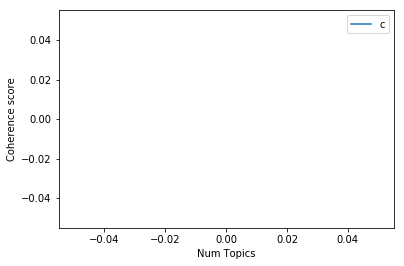

In [165]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Try Doc2Vec Gensim Approach
> * https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
> * https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

# Save and Reload WorkEnv

In [190]:
import dill
dill.dump_session('notebook_env.db')

# *Should we use DOC2VEC for training? perhaps word2vec for title & for the body of the posts?

In [5]:
import dill
dill.load_session('../ASUS/Desktop/Thesis/notebook_env.db')